In [9]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b")

In [11]:
llm.invoke("Hello, I am a student.").content

'Hello! It’s great to meet you. How can I help you today? Whether you have a question about a subject, need help with homework, or just want to chat, I’m here for you.'

In [13]:
#tavily
from langchain_tavily import TavilySearch
search = TavilySearch()

In [15]:
search.invoke("stock price of bloomberg?")

{'query': 'stock price of bloomberg?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.investing.com/indices/bbg-energy-tr',
   'title': 'Bloomberg Energy TR Index Today (BCOMENTR)',
   'content': 'The Bloomberg Energy TR live stock price is 70.8962. What is the ... The Bloomberg Energy TR stock price has ranged from 70.6678 to 72.2853. What',
   'score': 0.7623715,
   'raw_content': None},
  {'url': 'https://www.bloomberg.com/quote/WCAUWRLD:US',
   'title': 'Bloomberg World Exchange Market Capitalization USD ...',
   'content': 'Bloomberg World Exchange Market Capitalization USD. WCAUWRLD:US. (USD). 152,951,121.37. 1,851,835.48–1.20%. As of 12:00 AM EST 02/05/26 .',
   'score': 0.6633424,
   'raw_content': None},
  {'url': 'https://finance.yahoo.com/quote/%5EEST/',
   'title': 'NYSE Bloomberg Global Energy Sm (^EST)',
   'content': "NYSE Bloomberg Global Energy Sm (^EST) ; Previous Close 1,930.51 ; Open 1,932.44 ; Volume 0 ; Day's Range 

In [16]:
code = """
x = 10
y = x + 10
print(y)
"""

In [17]:
from langchain_experimental.utilities import PythonREPL

In [18]:
repl=PythonREPL()

In [20]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'20\n'

In [24]:
from langchain_core.tools import tool
from typing import Annotated

@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\npython\n{code}\nStdout: {result}"
    return result_str

In [26]:
python_repl_tool.invoke(code)

'Successfully executed:\npython\n\nx = 10\ny = x + 10\nprint(y)\n\nStdout: 20\n'

In [27]:
members = ["researher", "coder"]

In [28]:
options =  members + ["FIBISH"]

In [ ]:
options

['researher', 'coder', 'FIBISH']

In [30]:
from typing import Literal

In [31]:
from typing_extensions import TypedDict

In [33]:
class Router(TypedDict):
    next: Literal["researcher", "coder", "FIBISH"]

In [34]:
from langgraph.graph import MessagesState, START, END, StateGraph

In [66]:
class State(MessagesState):
    next: str

In [67]:
system_prompt = f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [68]:
from langgraph.types import Command, Literal

In [79]:
def supervisor_agent(state: State) -> Command[Literal['researcher','coder','__end__']]:
    messages = [{"role":"system", "context": system_prompt}] + state["messages"]
    llm_with_structure_output = llm.with_structured_output(Router)
    response = llm_with_structure_output.invoke(messages)

    goto=response["next"]
    if goto=="FINISH":
        goto = END
    else:
        return Command(goto=goto, update={"next":next})

In [80]:
from langgraph.prebuilt import create_react_agent

In [81]:
def researcher_agent(state: State) -> Command[Literal['supervisor']]:
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


In [82]:
def coder_agent(state: State) -> Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [83]:
workflow = StateGraph(State)

In [84]:
workflow.add_node('supervisor', supervisor_agent)

In [85]:
workflow.add_node('researcher', researcher_agent)

In [86]:
workflow.add_node('coder', coder_agent)

In [87]:
workflow.add_edge(START, 'supervisor')

In [88]:
app = workflow.compile()

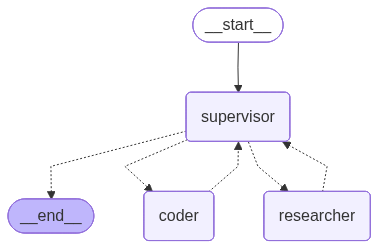

In [89]:
app